title: "05_HDCA_heart_cell_cell_communication"
author: "Raphaël Mauron"

## 05_HDCA_heart_cell_cell_communication

This code was run in a Jupyter notebook from a server.

Cell-cell communication using CellPhoneDB on liana is performed.

NOTE: The path to load the data and the path to save the figures should be changed at your convenience.

Environment: **Conda: liana**

### Set environment variables, load data and load libraries

In [1]:
# know your current working directory
getwd()

[1] "/home/raphael.mauron/projects/hdca_devheart"

In [2]:
# load libraries
library(Seurat)
library(tidyverse)
library(magrittr)
library(liana)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: 'SeuratObject'


The following object is masked from 'package:base':

    intersect


-- Attaching core tidyverse packages -------------------------------------------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts -------------------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'magrittr'


The following object is masked from 'package:purrr':

    set_names


The following object is masked from 'package:tidy

In [3]:
# load Seurat object for the subset of interest
data <- readRDS("./rds_object/HDCA_heart_sc_full_extended.rds")

In [4]:
data

An object of class Seurat 
58144 features across 76991 samples within 1 assay 
Active assay: RNA (58144 features, 3996 variable features)
 3 layers present: counts, data, scale.data
 4 dimensional reductions calculated: pca, umap_df, harmony_oi, umap_oi

In [5]:
set.seed(1)

## Prepare deep level annotation

In [6]:
data_curated <- data[, data$high_level_clusters %in% c("1", "2", "3", "4_35", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18_1", "18_2", "20", "21", "22", "23", "24", "25", "26", "28", "29", "30", "31", "32", "33", "34")]

In [7]:
data_curated <- FindVariableFeatures(data_curated, nfeatures = 5000)
var.features <- data_curated@assays$RNA@var.features

In [8]:
sampled_cells <- data_curated[[]] %>% 
  tibble::rownames_to_column(var = "barcode") %>% 
  group_by(high_level_clusters)
rm(data_curated)

In [9]:
annotation <- sampled_cells %>% 
  select(barcode, high_level_clusters, age_groups) %>% 
  data.frame(row.names = 1)
colnames(annotation) <- c("bio_celltype", "age_groups")

In [10]:
# Load annotations prepared earlier and filter
# CM
cardiomyocyte_clusters_keep <- c("1", "2", "3", "4-1", "4-2", "5", "6", "7", "8-1", "8-2", "8-3", "9", "10", "12", "14", "17", "18", "19-1", "19-2")
cardiomyocyte_metadata <- readRDS("./rds_object/cardiomyocyte_metadata.rds") %>% 
  mutate(clusters_subset = paste0("CM_", as.character(clusters_subset))) %>%  # rename cardiomyocyte clusters by adding a prefix CM_
  mutate_if(is.factor, as.character) %>% 
  filter(clusters_subset_split %in% cardiomyocyte_clusters_keep)

# EN
endothelial_clusters_keep <- c("1", "2", "3", "5", "6", "7", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21")
endothelial_metadata <- readRDS("./rds_object/endothelial_metadata.rds") %>% 
  filter(clusters_subset %in% endothelial_clusters_keep) %>% 
  mutate(clusters_subset = paste0("EN_", as.character(clusters_subset))) # rename endothelial clusters by adding a prefix EN_

# FB
fibroblasts_clusters_keep <- c("1", "2", "3", "4", "5", "6", "7", "8", "9", "11", "12", "13", "14", "15", "17", "18", "19", "20")
fibroblasts_metadata <- readRDS("./rds_object/fibroblasts_metadata.rds") %>% 
  filter(clusters_subset %in% fibroblasts_clusters_keep) %>% 
  mutate(clusters_subset = paste0("FB_", as.character(clusters_subset))) # rename fibroblasts clusters by adding a prefix FB_

# IN
innervation_clusters_keep <- c("1", "3", "4", "7", "8", "11", "12", "13", "17", "19")
innervation_metadata <- readRDS("./rds_object/innervation_metadata.rds") %>% 
  filter(clusters_subset %in% innervation_clusters_keep) %>% 
  mutate(clusters_subset = paste0("IN_", as.character(clusters_subset))) # rename innervation clusters by adding a prefix IN_

# Merge deep level clusters from the three different subsets
deep_clusters <- cardiomyocyte_metadata %>% 
  select(clusters_subset, clusters_subset_split) %>% # Only select clustering results
  bind_rows(endothelial_metadata %>% select(clusters_subset)) %>% # Add endothelial clusters
  bind_rows(fibroblasts_metadata %>% select(clusters_subset)) %>% # Add fibroblast clusters
  bind_rows(innervation_metadata %>% select(clusters_subset)) %>% # Add innervation clusters
  mutate(clusters_subset_split = case_when(is.na(clusters_subset_split) ~ clusters_subset, # rename cardiomyocyte clusters by adding a prefix CM_
                                           TRUE ~ paste0("CM_", clusters_subset_split)))

# Define clusters to keep
keep_clusters <- c(paste0("HL_", c("6", "8", "10", "15", "18_1", "20", "22", "29", "34")), 
                   paste0("CM_", cardiomyocyte_clusters_keep),
                   paste0("EN_", endothelial_clusters_keep),
                   paste0("FB_", fibroblasts_clusters_keep),
                   paste0("IN_", innervation_clusters_keep))


# Create a new annotations tibble
annotation_split <- annotation 
annotation_split <- annotation_split %>% 
  rownames_to_column(var = "ID") %>% 
  left_join(y = deep_clusters %>% rownames_to_column(var = "ID"), by = "ID") %>% 
  mutate(clusters_subset_split = case_when(is.na(clusters_subset_split) ~ paste0("HL_", bio_celltype),
                                           TRUE ~ clusters_subset_split)) %>% 
  filter(clusters_subset_split %in% keep_clusters) # keep selected clusters

# Convert clusters_subset_split to a factor and set order of clusters
annotation_split <- annotation_split %>% 
  mutate(clusters_subset_split = factor(clusters_subset_split, keep_clusters))

# Check overlap (sanity check)
all(annotation$ID %in% colnames(data))

rm(annotation, cardiomyocyte_metadata, deep_clusters, endothelial_metadata, fibroblasts_metadata, sampled_cells, cardiomyocyte_clusters_keep, endothelial_clusters_keep, fibroblasts_clusters_keep, keep_clusters)
gc()

[1] TRUE

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9411019,502.7,14267021,762.0,11750119,627.6
Vcells,1045195901,7974.3,2103848513,16051.1,2103848433,16051.1


In [11]:
data <- data[, colnames(data) %in% annotation_split$ID]
data$clusters_subset_split <- as.character(annotation_split$clusters_subset_split)

## Run CellPhoneDB

### Selection interaction

### CM_18, CM_4-2, CM_4-1, EN_1, EN_12 (Supp Fig. 7B)

In [12]:
clusters_to_analyze <- c("CM_18", "CM_4-2", "CM_4-1", "EN_1", "EN_12")

In [13]:
my_niche <- annotation_split[annotation_split$clusters_subset_split %in% clusters_to_analyze,]
data_niche <- data[, colnames(data) %in% my_niche$ID]

table(data_niche$clusters_subset_split)


 CM_18 CM_4-1 CM_4-2   EN_1  EN_12 
   164    454    279   2310    778 

In [14]:
# Recalculate the cpdb scores
cpdb_data <- liana_wrap(data_niche,
                        method = 'cellphonedb',
                        resource = c('CellPhoneDB'),
                        idents_col = "clusters_subset_split",
                        permutation.params = list(nperms=100,
                                                  parallelize=FALSE,
                                                  workers=4),
                        expr_prop=0.05)

# identify interactions of interest
cpdb_int <- cpdb_data %>%
  # only keep interactions with p-val <= 0.05
  filter(pvalue <= 0.05) %>% # this reflects interactions `specificity`
  # then rank according to `magnitude` (lr_mean in this case)
  rank_method(method_name = "cellphonedb",
              mode = "magnitude") %>%
  # keep top 20 interactions (regardless of cell type)
  distinct_at(c("ligand.complex", "receptor.complex")) %>%
  head(100)

# Plot results
p <- cpdb_data %>%
     # keep only the interactions of interest
     inner_join(cpdb_int, 
             by = c("ligand.complex", "receptor.complex")) %>%
     # invert size (low p-value/high specificity = larger dot size)
     # + add a small value to avoid Infinity for 0s
     mutate(pvalue = -log10(pvalue + 1e-10)) %>% 
     liana_dotplot(source_groups = clusters_to_analyze,
                   target_groups = clusters_to_analyze,
                   ntop = NULL,
                   specificity = "pvalue",
                   magnitude = "lr.mean",
                   show_complex = TRUE,
                   size.label = "-log10(p-value)")

Expression from the `RNA` assay will be used

Running LIANA with `clusters_subset_split` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
"25044 genes and/or 0 cells were removed as they had no counts!"
Warning message:
"`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours."
LIANA: LR summary stats calculated!

Now Running: Cellphonedb

Warning message:
"`progress_estimated()` was deprecated in dplyr 1.0.0.
i The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>."


In [15]:
selected_interaction <- c("NRG1 -> ERBB4", 
                          "NRG3 -> ERBB4",
                          "HBEGF -> ERBB4", 
                          "NPPA -> NPR1", 
                          "SEMA3A -> NRP1")

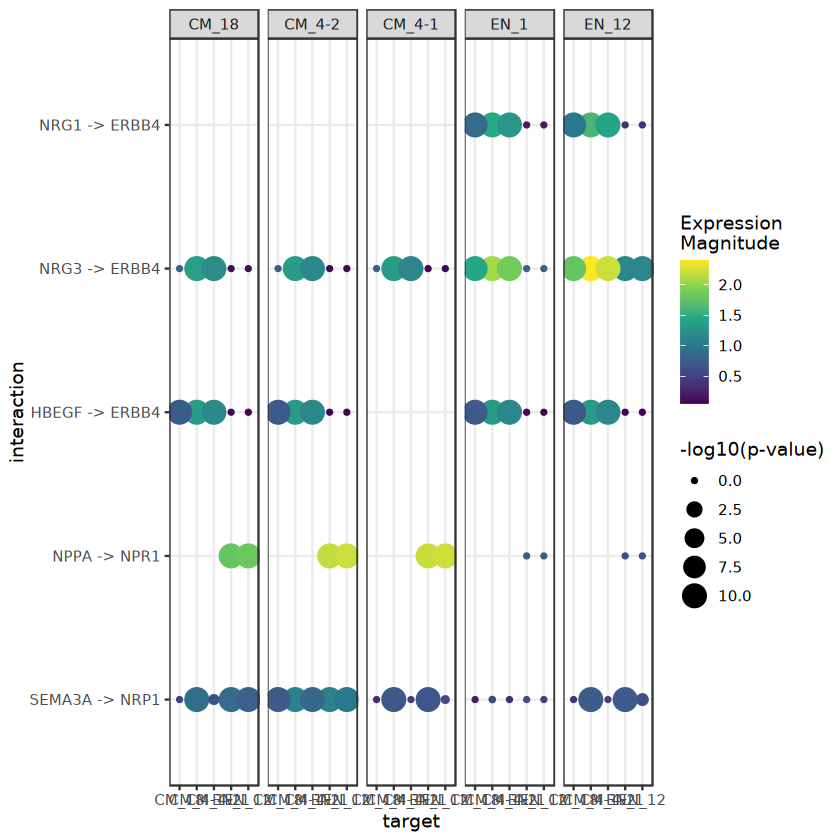

In [16]:
filtered_data <- p$data %>%
  filter(interaction %in% selected_interaction)

filtered_data$interaction <- factor(filtered_data$interaction, levels = rev(selected_interaction))
filtered_data$source <- factor(filtered_data$source, levels = clusters_to_analyze)

# Create a new ggplot object using the filtered data and faceting by source
p1 <- ggplot(filtered_data, aes(x = target, y = interaction, colour = magnitude, size = specificity)) +
  geom_point() +
  theme_bw() +
  scale_colour_viridis_c(name = "Expression\nMagnitude") +
  labs(size = "-log10(p-value)") +
  facet_grid(. ~ source, scales = "free_x", space = "free_x")

# Print the new ggplot object
print(p1)

In [17]:
as.character(clusters_to_analyze)

[1] "CM_18"  "CM_4-2" "CM_4-1" "EN_1"   "EN_12"

In [18]:
#save plot
pdf(file = paste0("output/", "CM_18_CM_4-2_CM_4-1_EN_1_EN_12", "_dotplot_cpdb_magnitude_selection_interaction.pdf"), width = 9, height = 3.5)
p1
dev.off()

png 
  2

## SAN_CM (CM_19_2), CALN1high_FB (FB_17), Aut_Neu_2 (IN_13)

In [14]:
clusters_to_analyze <- c("CM_19-2", "FB_17", "IN_13")

In [15]:
my_niche <- annotation_split[annotation_split$clusters_subset_split %in% clusters_to_analyze,]
data_niche <- data[, colnames(data) %in% my_niche$ID]

table(data_niche$clusters_subset_split)


CM_19-2   FB_17   IN_13 
    299     586      69 

In [16]:
# Recalculate the cpdb scores
cpdb_data <- liana_wrap(data_niche,
                        method = 'cellphonedb',
                        resource = c('CellPhoneDB'),
                        idents_col = "clusters_subset_split",
                        permutation.params = list(nperms=100,
                                                  parallelize=FALSE,
                                                  workers=4),
                        expr_prop=0.05)

# identify interactions of interest
cpdb_int <- cpdb_data %>%
  # only keep interactions with p-val <= 0.05
  filter(pvalue <= 0.05) %>% # this reflects interactions `specificity`
  # then rank according to `magnitude` (lr_mean in this case)
  rank_method(method_name = "cellphonedb",
              mode = "magnitude") %>%
  # keep top 20 interactions (regardless of cell type)
  distinct_at(c("ligand.complex", "receptor.complex")) %>%
  head(100)

# Plot results
p <- cpdb_data %>%
     # keep only the interactions of interest
     inner_join(cpdb_int, 
             by = c("ligand.complex", "receptor.complex")) %>%
     # invert size (low p-value/high specificity = larger dot size)
     # + add a small value to avoid Infinity for 0s
     mutate(pvalue = -log10(pvalue + 1e-10)) %>% 
     liana_dotplot(source_groups = clusters_to_analyze,
                   target_groups = clusters_to_analyze,
                   ntop = NULL,
                   specificity = "pvalue",
                   magnitude = "lr.mean",
                   show_complex = TRUE,
                   size.label = "-log10(p-value)")

Expression from the `RNA` assay will be used

Running LIANA with `clusters_subset_split` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
"29658 genes and/or 0 cells were removed as they had no counts!"
Warning message:
"`invoke()` is deprecated as of rlang 0.4.0.
Please use `exec()` or `inject()` instead.
This warning is displayed once every 8 hours."
LIANA: LR summary stats calculated!

Now Running: Cellphonedb

Warning message:
"`progress_estimated()` was deprecated in dplyr 1.0.0.
i The deprecated feature was likely used in the liana package.
  Please report the issue at <https://github.com/saezlab/liana/issues>."


png 
  2

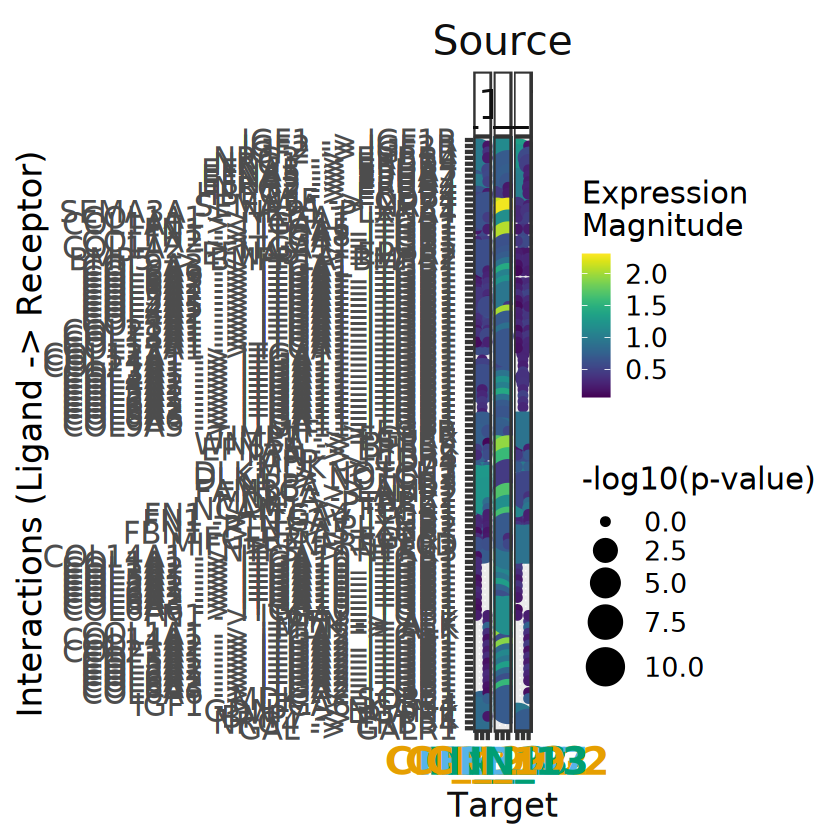

In [22]:
print(p)

#save plot
pdf(file = paste0("output/", "CM_19-2_FB_17_IN_13", "_dotplot_cpdb_magnitude_selection_interaction.pdf"), width = 20, height = 30)
p
dev.off()

## SAN_CM (CM_19_2), AVN_CM (CM_19_1), Ven_EC (EN_16)

In [23]:
clusters_to_analyze <- c("CM_19-2", "CM_19-1", "EN_16")

In [24]:
my_niche <- annotation_split[annotation_split$clusters_subset_split %in% clusters_to_analyze,]
data_niche <- data[, colnames(data) %in% my_niche$ID]

table(data_niche$clusters_subset_split)


CM_19-1 CM_19-2   EN_16 
    147     299     166 

In [25]:
# Recalculate the cpdb scores
cpdb_data <- liana_wrap(data_niche,
                        method = 'cellphonedb',
                        resource = c('CellPhoneDB'),
                        idents_col = "clusters_subset_split",
                        permutation.params = list(nperms=100,
                                                  parallelize=FALSE,
                                                  workers=4),
                        expr_prop=0.05)

# identify interactions of interest
cpdb_int <- cpdb_data %>%
  # only keep interactions with p-val <= 0.05
  filter(pvalue <= 0.05) %>% # this reflects interactions `specificity`
  # then rank according to `magnitude` (lr_mean in this case)
  rank_method(method_name = "cellphonedb",
              mode = "magnitude") %>%
  # keep top 20 interactions (regardless of cell type)
  distinct_at(c("ligand.complex", "receptor.complex")) %>%
  head(100)

# Plot results
p <- cpdb_data %>%
     # keep only the interactions of interest
     inner_join(cpdb_int, 
             by = c("ligand.complex", "receptor.complex")) %>%
     # invert size (low p-value/high specificity = larger dot size)
     # + add a small value to avoid Infinity for 0s
     mutate(pvalue = -log10(pvalue + 1e-10)) %>% 
     liana_dotplot(source_groups = clusters_to_analyze,
                   target_groups = clusters_to_analyze,
                   ntop = NULL,
                   specificity = "pvalue",
                   magnitude = "lr.mean",
                   show_complex = TRUE,
                   size.label = "-log10(p-value)")

Expression from the `RNA` assay will be used

Running LIANA with `clusters_subset_split` as labels!

`Idents` were converted to factor

Warning message in exec(output, ...):
"31127 genes and/or 0 cells were removed as they had no counts!"
LIANA: LR summary stats calculated!

Now Running: Cellphonedb



png 
  2

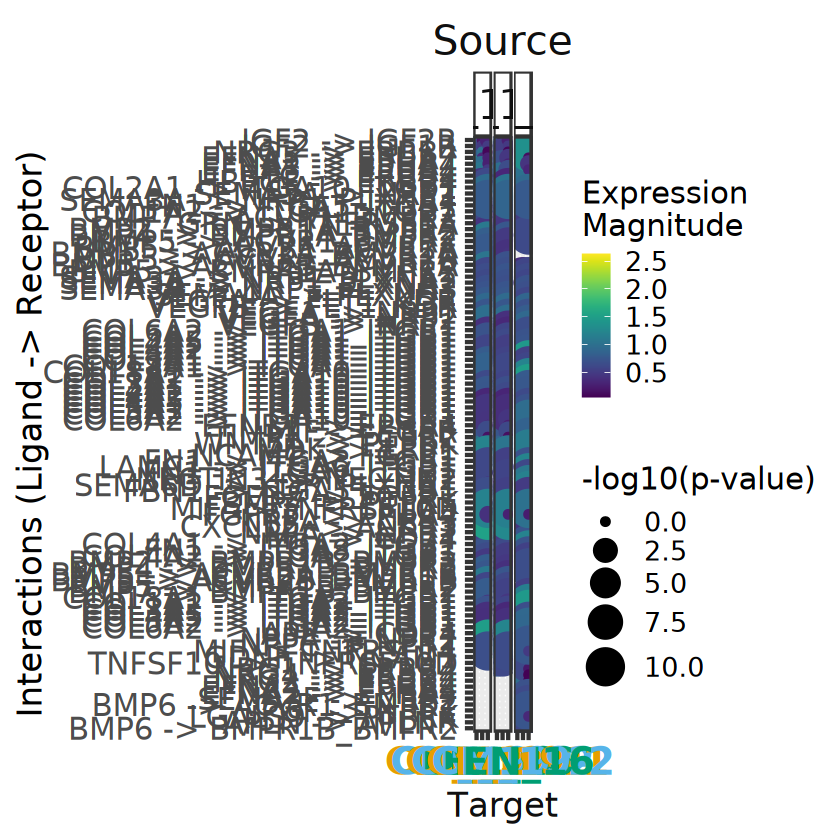

In [26]:
print(p)

#save plot
pdf(file = paste0("output/", "CM_19-1_CM_19-2_EN_16", "_dotplot_cpdb_magnitude_selection_interaction.pdf"), width = 20, height = 30)
p
dev.off()